In [1]:
import numpy as np #para manejo de vectores
import matplotlib.pyplot as plt #para gráficas
import math # para operaciones matemáticas
import random #para números aleatorios
# %matplotlib notebook
import time

Valores iniciales:
Los vectores son de dimensión $dim = 10$

El dominio de cada coordenada es $[xmin,xmax] = [-10,10]$

La población inicial es de 100 individuos

Se generan vectores de manera aleatoria uniforme, considerando el artículo de Ono acerca de UNDX, el valor de la varianza para el eje principal es 
$$\sigma^2_\xi=\frac{1}{4}$$ 
y para el espacio ortogonal: 
$$\sigma^2_\eta=\frac{2}{3(n-1)} =  \frac{2}{9}$$ 

pues $n=dim =10$. 

Este es un algoritmo genético que sigue la propuesta de Ono: 
* Generar de manera aleatoria vectores de dimensión 10
* Elegir dos individuos de manera aleatoria sin reemplazo
* Generar decendencia aplicando UNDX a los individuos elegidos, se repite este proceso $n_c$ veces para crear $2\times n_c$ decendientes
* Sobreviven dos individuos de la familia que contiene a los padres y su decendencia; uno es el mejor individuo y el otro es elegido mediante ruleta. Los elementos reemplazan a los padres en la población
* Se repiten los pasos anteriores hasta algún criterio de paro



In [2]:
dim = 10
xmin = -5.12
xmax = 5.12

vareta =0.074
varxi = 0.25

prob_sel = 0.75
pobsize = 250
n_c = 100
pob_mut= 0.01
maxiter = 3000

In [3]:
########### Norma de un vector para ahorrar notación #################
def norma(v):
    return np.linalg.norm(v)

In [4]:
############ Generar vectores n dimensionales de manera aleatoria uniforme ##############
def create_pob(pobsize):
    pob = []
    for i in range(pobsize):
        vector = []
        for j in range(dim):
#             x = random.uniform(-5.12,5.12)
            x = np.random.normal(0, 5.12)
            vector.append(x)            
        vector = np.array(vector)
        pob.append(vector)
    return pob           

In [5]:
########## Función fitness a optimizar, hallar mínimo en este caso ###########
def aptitud(x):    
    suma = np.sum(x**2 - 10 * np.cos(2 * np.pi * x))
    resultado = 10*dim + suma
    return resultado

In [6]:
##############################################################
# Calcula el complemento ortogonal de un vector              #
# El resultado es una base de n-1 elementos de dimension n   #
##############################################################
def orthogonal_vectors(base_vector, num_vectors = dim -1):
    vectors = []
    while len(vectors) < num_vectors:
        vec = np.random.rand(dim)
        for v in vectors + [base_vector]:
            epsilon = 1e-8  #np batalla para dividir entre números pequeños
            vec -= np.dot(vec, v) / (np.dot(v, v) + epsilon) * v #sumo un número pequeño para evitar errores
        if norma(vec) > 1e-5:  
            vectors.append(vec / norma(vec))  
    return np.array(vectors)

In [7]:
##############################################
# Genera el elemento del espacio ortogonal   #
# usando la varianza teorica                 #
##############################################
def gen_corth(base):
    vect = 0
    for i in base:
        etai = np.random.normal(0,np.sqrt(vareta))
        vect += etai * i
    return vect

In [8]:
def mut_uniform(childs, prob_mut):
    for child in childs:
        for i in range(len(child)):
            if np.random.rand() < prob_mut:
                child[i] = np.random.uniform(xmin,xmax)
    return childs

In [9]:
###############################################################
# Segun ono sobrevive el mejor y el que gane                  #
# ruleta, la ruleta esta basada en la aptitud                 #
# como se intenta minimizar tomo el inverso multiplicativo    #
# para que la menor aptitud tenga mayor probabilidad          #
# de ser elegida                                              #
###############################################################
def survival_selection(family):
    best = min(family, key=lambda individual: aptitud(individual))
    weights = [1.0 / (aptitud(ind) + 1e-6) for ind in family]  
    roulette_selection = random.choices(family, weights=weights, k=1)[0]
    return best, roulette_selection


In [10]:
def torneo_binario_probabilistico(poblacion, probabilidad):
    # Calcular aptitud para cada individuo en la población
    aptitudes = np.array([aptitud(individuo) for individuo in poblacion])
    
    # Seleccionar dos individuos al azar
    indices = np.random.choice(len(poblacion), size=2, replace=False)
    individuo_1, individuo_2 = indices[0], indices[1]

    # Obtener sus aptitudes
    aptitud_1 = aptitudes[individuo_1]
    aptitud_2 = aptitudes[individuo_2]

    # Determinar el ganador
    if aptitud_1 > aptitud_2:
        mejor = individuo_1
        peor = individuo_2
    else:
        mejor = individuo_2
        peor = individuo_1

    # Selección probabilística
    if np.random.rand() < probabilidad:
        return poblacion[mejor]
    else:
        return poblacion[peor]
    
def seleccionar_pares(poblacion, probabilidad):
    padre1 = torneo_binario_probabilistico(poblacion, probabilidad)
    padre2 = padre1
    while np.array_equal(padre2, padre1):
        padre2 = torneo_binario_probabilistico(poblacion, probabilidad)
    return padre1, padre2

In [11]:
#################################################################
# Operador undx, recibe a la población y arroja a la población  #
# con el reemplazo hecho por la ruleta  y el mejor              #
#################################################################
def undx(pob, n_c,pob_mut, prob_sel):
    epsilon = 1e-8
    x3 = random.choice(pob) 
    x1,x2 =  seleccionar_pares(pob, prob_sel)
    xp = 0.5 * (x2 + x1)
    d = x2 - x1
    offspring = []

    for _ in range(n_c):
        x31 = x3 - x1
        x21 = x2 - x1
        D = math.sqrt(norma(x31)**2 * (1 - (np.dot(x31, x21) / (norma(x31) * norma(x21) + epsilon))**2))
        orth_vects = orthogonal_vectors(d, num_vectors=dim-1)
        comp_orth = gen_corth(orth_vects)
        xi = np.random.normal(0, np.sqrt(varxi))
        x_c = xp + xi * d + comp_orth
        x_c2 = xp - xi * d - comp_orth
        offspring.extend([x_c, x_c2])
         
    offspring = mut_uniform(offspring,pob_mut)

    family = [x1, x2, x3] + offspring
    
    best, roulette = survival_selection(family)    

    for idx in range(len(pob)):
        if np.array_equal(pob[idx], x1):
            pob[idx] = best
            break

    for idx in range(len(pob)):
        if np.array_equal(pob[idx], x2):
            pob[idx] = roulette
            break

    sorted_pob = sorted(pob, key=lambda individual: aptitud(individual))

    return sorted_pob

In [12]:
inpob = create_pob(pobsize)
# x = np.array([arr[0] for arr in inpob])
# y = np.array([arr[1] for arr in inpob])
# z = np.array([arr[2] for arr in inpob])

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')


# scatter = ax.scatter(x, y,z,  alpha =0.8)

# ax.set_xlabel('X Coordinate')
# ax.set_ylabel('Y Coordinate')
# ax.set_zlabel('Z Coordinate')

# plt.show()

In [13]:
resultados1 = {}
graficas = {}
for j in range(30):
    start_time = time.time()

    resultados= []
    inpob = create_pob(pobsize)
    for i in range(maxiter):
        inpob = undx(inpob, n_c,pob_mut,prob_sel)
        resultados.append(aptitud(inpob[0]))
    graficas[j] = resultados
    resultados1[j]=inpob
    print(f"la mejor aptitud en la ejecución {j+1} es: {aptitud(inpob[0])}")

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"------\nEl tiempo de ejecución es: {elapsed_time} segundos\n------")

la mejor aptitud en la ejecución 1 es: 13.54602049201273
------
El tiempo de ejecución es: 131.47713446617126 segundos
------
la mejor aptitud en la ejecución 2 es: 10.805407496861065
------
El tiempo de ejecución es: 132.42851567268372 segundos
------
la mejor aptitud en la ejecución 3 es: 8.436372858872062
------
El tiempo de ejecución es: 135.66439867019653 segundos
------
la mejor aptitud en la ejecución 4 es: 6.191364627210902
------
El tiempo de ejecución es: 137.01026678085327 segundos
------
la mejor aptitud en la ejecución 5 es: 13.38254846611909
------
El tiempo de ejecución es: 137.55862140655518 segundos
------
la mejor aptitud en la ejecución 6 es: 11.506267868511998
------
El tiempo de ejecución es: 128.37121891975403 segundos
------
la mejor aptitud en la ejecución 7 es: 11.96666730334141
------
El tiempo de ejecución es: 127.98003125190735 segundos
------
la mejor aptitud en la ejecución 8 es: 9.469984829360513
------
El tiempo de ejecución es: 128.9002947807312 segundo

In [14]:
vectores = []
aptitudes = []

for k in range(30):
    vectores.append(resultados1[k][0])
    aptitudes.append(aptitud(resultados1[k][0]))



In [15]:
import pandas as pd
df = pd.DataFrame(vectores)
df['mejores_aptitudes'] = aptitudes

# Exportar el DataFrame a un archivo CSV
df.to_csv('real_2.csv', index=False)

<IPython.core.display.Javascript object>


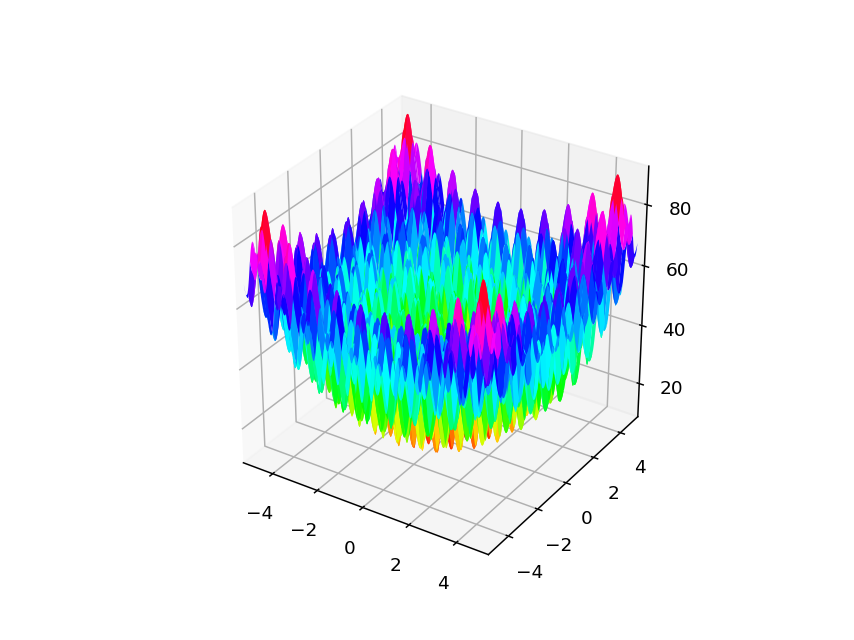

In [27]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D


def funcion(x, y):
    return 30 + (x**2 - 10 * np.cos(2 * np.pi * x)) + (y**2 - 10 * np.cos(2 * np.pi * y))


x = np.linspace(-5.12, 5.12, 400)
y = np.linspace(-5.12, 5.12, 400)
X, Y = np.meshgrid(x, y)
Z = funcion(X, Y)


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='hsv')


ax.set_xlim([-5.12, 5.12])
ax.set_ylim([-5.12, 5.12])
ax.set_zlim([np.min(Z), np.max(Z)])


ax.set_box_aspect([1,1,1])  


plt.show()

In [17]:
vect = [np.array([1.2,2.69,-3.6]), np.array([2,9,8])]

In [18]:
[aptitud(x) for x in vect]

[130.3173455268468, 219.0]

In [19]:
np.random.normal(0, 5.12)

-0.8369912383533212

In [28]:
df

,0,1,2,3,4,5,6,7,8,9,mejores_aptitudes
23,0.022566,0.029237,0.053917,0.006504,0.026846,-0.022613,0.035212,-0.015029,-0.082532,1.018443,3.809119
3,0.023787,-1.000322,-0.958161,0.036871,0.048488,0.042044,0.005551,-0.055322,0.096630,-0.041097,6.191365
2,-0.994351,0.000309,0.026916,-0.983118,-0.047834,-0.086415,-0.030949,-0.102454,-0.032404,-0.924087,8.436373
7,-0.096782,-0.033598,0.034143,0.958458,0.006238,0.969918,1.066043,1.065820,0.053822,0.038793,9.469985
25,0.136966,0.016357,0.995518,0.054195,0.037038,-0.984697,-0.118106,-0.004750,-0.031828,-0.039295,9.563670
27,-0.014545,-0.002660,-0.011084,0.091977,-0.973644,0.085492,-0.027705,-0.067585,0.126498,0.085789,9.682272
29,-0.085165,-0.095761,0.113491,-0.071237,0.026582,0.033332,-0.057200,-0.046699,-0.009156,1.052976,9.715557
15,-0.022045,1.927679,0.009342,0.055513,0.066122,-0.006927,0.028808,-0.985585,1.073256,0.053712,10.250253
11,0.999701,0.051455,0.043515,0.067831,-0.108255,0.039224,0.009165,-0.039037,0.078748,-0.135323,10.276922
9,0.076092,-1.011834,-0.054872,-0.066051,-0.021165,0.083397,0.053834,-0.144536,-0.062429,-0.013260,10.297297


In [21]:
df = df.sort_values(by='mejores_aptitudes')

In [29]:
df.to_csv('undx_2_ejecuciones.csv', index=True, index_label='mi_indice')

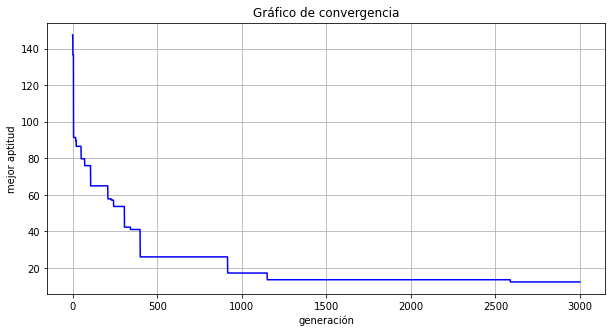

In [24]:
plt.figure(figsize=(10, 5))  # Crea una figura con un tamaño específico
plt.plot(graficas[22],  linestyle='-', color='b')
plt.title('Gráfico de convergencia')  
plt.xlabel('generación')  
plt.ylabel('mejor aptitud')  
plt.grid(True)

plt.show()

In [25]:
df.to_csv('undx_2_ejecuciones.csv', index=False)

In [26]:
import csv

# Guardar la lista en un archivo CSV
with open('mediana_undx_2.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(graficas[22])